<a href="https://colab.research.google.com/github/AditiDuggal/Parkinson-s-Triples/blob/main/TransD_Pipeline_ipynb_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SPARQLWrapper requests pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 15.1 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/pykeen/pykeen.git

  Cloning https://github.com/pykeen/pykeen.git to /tmp/pip-req-build-duk10pod
  Running command git clone --filter=blob:none --quiet https://github.com/pykeen/pykeen.git /tmp/pip-req-build-duk10pod
  Resolved https://github.com/pykeen/pykeen.git to commit bd16be8a1d6f73599a52fd565725fec9d9688417
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
  Created wheel for pykeen: filename=pykeen-1.11.2.dev0-py3-none-any.whl size=731250 sha256=d5a654c19ebbc8454018f69ba893a4ddfb938581b24660185c6b47ea75e69ef9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pwa_luq3/wheels/aa/4f/9a/ff62adcf76b57265e0f70c21a877bb365beb0bc7b0aabaf40a
Successfully built pykeen


In [ ]:
import json
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import requests
from SPARQLWrapper import SPARQLWrapper, JSON
from pykeen.triples import TriplesFactory

INFO:pykeen.utils:Using opt_einsum


In [ ]:
import logging, sys, time, json, csv, re
#set up logging
LOG_DIR = Path("./wd_debug")
LOG_DIR.mkdir(parents=True, exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler(sys.stdout),
              logging.FileHandler(LOG_DIR / "wikidata_debug.log", encoding="utf-8")],
)
logger = logging.getLogger("wikidata-debug")

In [ ]:
manual: Dict[str, str] = {
  "AD": "Alzheimer's disease",
  "5-HT": "Serotonin",
  "6-OHDA": "6-hydroxydopamine",
  "MPP+": "1-methyl-4-phenylpyridinium",
  "A. muciniphila": "Akkermansia muciniphila",
  "alpha-synuclein": "Alpha-synuclein",
  "butyrate": "Butyrate",
  "gut microbiota": "Gut microbiota",
  "PD": "Parkinson's disease",
  "Lewy bodies": "Lewy body",
  "PCD": "Programmed cell death",
  "6-OHDA": "6-hydroxydopamine",
  "FMT": "Fecal microbiota transplantation",
  "IBD": "Inflammatory bowel disease",
  "Proteins": "Protein",
  "Probiotics": "Probiotic",
  "UC": "Ulcerative colitis",
  "ATP": "Adenosine triphosphate",
  "MPTP": "1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine",
  "TNF-α": "Tumor necrosis factor alpha",
  "SCFA": "Short-chain fatty acid",
  "NO": "Nitric oxide",
  "ROS": "Reactive oxygen species",
  "the UPDRS": "Unified Parkinson's disease rating scale",
  "gut microbiota dysbiosis": "Dybiosis",
  "BMS": "Burning Mouth Syndrome",
  "SLPI": "Secretory Leukocyte Protease Inhibitor",
  "OTU": "Operational Taxonomic Unit",
  "GI": "Gastrointestinal Tract",
  "IBD": "Irritable Bowel Disease",
  "EGCs": "Electrocardiogram",
  "plantarum PFM": " Lactobacillus plantarum",
  "CRC": "Colorectal Cancer",
  "putamenal DA": "Putaminal Dopamine",
  "UC": "ulcerative colitis",
  "LBs": "Lewy Bodies",
  "PCD": "Primary Ciliary Dyskinesia",
}

def clean_label(s: str) -> str:
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)                       # collapse spaces
    s = re.sub(r'\s-\s', '-', s)                     # fix spaced hyphens
    s = re.sub(r'^[,;:\-\u2013\u2014]+\s*', '', s)   # leading punctuation
    s = re.sub(r'\(\s*aged [^)]+\)', '', s, flags=re.I)
    s = re.sub(r'(kg\s*/\s*m2|%|ppm|mg/L|<|>|≤|≥)', '', s, flags=re.I)
    # corpus fixes
    s = s.replace('Constip ation', 'Constipation')
    s = s.replace('Mehtyl', 'Methyl')
    s = s.replace('A . muciniphila', 'Akkermansia muciniphila')
    s = s.replace('alpha - synuclein', 'alpha-synuclein')
    s = s.replace('biﬁ', 'bifi').replace('Biﬁ', 'Bifi')
    return s.strip()

def is_entity_like(s: str) -> bool:
    if not s or len(s) < 3: return False
    if re.search(r'^\d+(\.\d+)?\s*$', s): return False             # numbers
    if re.search(r'^(Acknowledgments|Introduction)\b', s, re.I): return False
    if re.search(r'^(Fig|Figure|Table|Supp(?:lement)?|S\d+)\b', s): return False
    if re.search(r'^[A-Z]?\d+[A-Z]?(?:\s*-\s*[A-Z])?\b', s): return False  # 7C-F etc.
    if len(s.split()) > 8: return False                            # likely a caption/sentence
    return True

def prepare_for_lookup(raw: str, manual_map: Dict[str,str]) -> List[str]:
    s = clean_label(raw)
    if not is_entity_like(s):
        return []
    if s in manual_map:
        return [manual_map[s]]  # manual takes priority
    # surface variants
    variants = {s, s.replace(' - ', '-'), s.replace('- ', '-'), s.replace(' -', '-')}
    return [v for v in variants if v]

In [ ]:
WIKIDATA_SEARCH = "https://www.wikidata.org/w/api.php"
CACHE_PATH = Path("qid_cache.json")
ATTEMPTS_CSV = LOG_DIR / "lookup_attempts.csv"

if not ATTEMPTS_CSV.exists():
    with open(ATTEMPTS_CSV, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(["raw","cleaned","entity_like","used_manual",
                                "candidate","http_status","qid","error"])

def load_cache() -> Dict[str, Optional[str]]:
    if CACHE_PATH.exists():
        return json.loads(CACHE_PATH.read_text(encoding="utf-8"))
    return {}

def save_cache(cache: Dict[str, Optional[str]]) -> None:
    CACHE_PATH.write_text(json.dumps(cache, ensure_ascii=False, indent=2), encoding="utf-8")

In [ ]:
def wd_search_label_once(label: str, language: str = "en") -> Tuple[Optional[str], Optional[int], Optional[str]]:
    headers = {"User-Agent": "LailahKG/1.0 (mailto:your_email@example.com)"}  # put your email
    params = {
        "action": "wbsearchentities",
        "search": label,
        "language": language,
        "format": "json",
        "type": "item",
        "limit": 1,
        "strict": 0,  # softer matching like your other function
    }
    backoff = 0.5
    for attempt in range(5):
        try:
            r = requests.get(WIKIDATA_SEARCH, params=params, headers=headers, timeout=20)
            status = r.status_code
            if status == 200:
                hits = r.json().get("search", [])
                return (hits[0]["id"] if hits else None, status, None)
            if status in (429, 502, 503, 504):
                time.sleep(backoff); backoff *= 2
                continue
            return (None, status, f"HTTP {status}")
        except Exception as e:
            err = str(e)
            time.sleep(backoff); backoff *= 2
            if attempt == 4:
                return (None, None, err)
    return (None, None, "max retries")

In [ ]:
def map_labels_to_qids(labels: List[str],
                       language: str = "en",
                       sleep_s: float = 0.15,
                       retry_null_cache: bool = True) -> Dict[str, Optional[str]]:
    cache = load_cache()
    out: Dict[str, Optional[str]] = {}

    for raw in labels:
        # respect cache unless we are retrying previous nulls
        if raw in cache and (cache[raw] is not None or not retry_null_cache):
            out[raw] = cache[raw]
            continue

        cleaned = clean_label(raw)
        entity_like = is_entity_like(cleaned)
        used_manual = int(cleaned in manual)
        candidates = prepare_for_lookup(raw, manual)

        qid: Optional[str] = None
        if not candidates:
            with open(ATTEMPTS_CSV, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([raw, cleaned, entity_like, used_manual, "", "", "", "filtered_out_or_no_candidates"])
            logger.debug(f"SKIP: {raw!r} -> {cleaned!r} (not entity-like)")
        else:
            for cand in candidates:
                qid, http_status, err = wd_search_label_once(cand, language=language)
                with open(ATTEMPTS_CSV, "a", newline="", encoding="utf-8") as f:
                    csv.writer(f).writerow([raw, cleaned, entity_like, used_manual, cand,
                                            http_status if http_status is not None else "",
                                            qid if qid else "", err if err else ""])
                logger.info(f"Lookup raw={raw!r} cleaned={cleaned!r} cand={cand!r} status={http_status} qid={qid} err={err}")
                if qid:
                    break

        cache[raw] = qid
        out[raw] = qid
        time.sleep(sleep_s)

    save_cache(cache)
    return out

In [ ]:
def fetch_wikidata_edges(qids: List[str]) -> List[Tuple[str, str, str]]:
    props = {"P31","P279","P361","P460","P171","P105"}
    endpoint = SPARQLWrapper("https://query.wikidata.org/sparql")
    triples: List[Tuple[str, str, str]] = []
    BATCH = 50
    batched = [qids[i:i+BATCH] for i in range(0, len(qids), BATCH)]

    for batch in batched:
        values = " ".join([f"wd:{qid}" for qid in batch])
        query = f"""
        SELECT ?s ?p ?o WHERE {{
          VALUES ?s {{ {values} }}
          ?s ?p ?o .
          FILTER(STRSTARTS(STR(?p), "http://www.wikidata.org/prop/direct/"))
          FILTER(STRSTARTS(STR(?o), "http://www.wikidata.org/entity/"))
        }}
        """
        endpoint.setQuery(query)
        endpoint.setReturnFormat(JSON)
        try:
            data = endpoint.query().convert()
            for b in data["results"]["bindings"]:
                p_iri = b["p"]["value"]
                pid = p_iri.rsplit("/", 1)[-1]   # P##
                if pid not in props:
                    continue
                s_q = b["s"]["value"].rsplit("/", 1)[-1]
                o_q = b["o"]["value"].rsplit("/", 1)[-1]
                triples.append((f"wd:{s_q}", f"wdt:{pid}", f"wd:{o_q}"))
        except Exception as e:
            logger.error(f"Error fetching wikidata edges for batch: {e}")
            # Continue with the next batch even if one fails
            pass
        time.sleep(1) # Add a delay of 1 second between batches


    triples = list(set(triples))
    return triples

In [ ]:
df = pd.read_csv('Combined Cleaned Triples CSV - Sheet1.tsv', sep='\t', header=None)
assert df.shape[1] == 3, "data.tsv must have exactly 3 tab-separated columns (head, relation, tail)."

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tests = ["Butyrate", "Alpha-synuclein", "Akkermansia muciniphila", "Gut microbiota"]
mini = map_labels_to_qids(tests, retry_null_cache=True)
for t in tests:
    print(t, "->", mini.get(t))

Butyrate -> Q1018145
Alpha-synuclein -> Q288591
Akkermansia muciniphila -> Q15020908
Gut microbiota -> Q739734


In [ ]:
entity_labels = sorted(set(df[0].tolist()) | set(df[2].tolist()))
label2qid = map_labels_to_qids(entity_labels)

In [ ]:
label2qid_df = pd.DataFrame(list(label2qid.items()), columns=['Label', 'Wikidata QID'])

display(label2qid_df)

,Label,Wikidata QID
0,( BMI < 25 kg / m2 ) Korean adolescents ( aged...,None
1,( re - known pathogenic - synuclein mutations,None
2,", butyrate",Q1018145
3,", serum antigen test Constip ation and defecat...",None
4,1 - Mehtyl - 4 - phenylpyridinium,None
...,...,...
1301,with constipation,None
1302,xylooligosaccharides,Q56816970
1303,your tummy,None
1304,α-syn-mediated neuro-inflammation,None


In [ ]:
def build_label2qid_from_df(map_df: pd.DataFrame,
                            label_col: str = "Label",
                            qid_col: str = "Wikidata QID") -> Dict[str, Optional[str]]:
    out: Dict[str, Optional[str]] = {}
    for _, row in map_df[[label_col, qid_col]].iterrows():
        label = str(row[label_col]).strip()
        qid = row[qid_col]
        # Accept QIDs that are either "Q123" or "wd:Q123" or numeric-r like "Q12345"
        if pd.isna(qid) or (isinstance(qid, str) and qid.strip().lower() in {"none", "nan", ""}):
            out[label] = None
        else:
            qid_str = str(qid).strip()
            # strip any "wd:" prefix so values are canonical "Q123" strings or keep if already "Q..."
            if qid_str.startswith("wd:"):
                qid_str = qid_str.split(":", 1)[1]
            out[label] = qid_str
    return out

In [ ]:
def remap_entities_to_qids(df: pd.DataFrame,
                           label2qid: Dict[str, Optional[str]],
                           head_col_idx: int = 0,
                           tail_col_idx: int = 2) -> pd.DataFrame:
    """
    Replace heads/tails using label2qid mapping.
    If a mapping exists for the exact label, use wd:QID.
    If the cell already looks like 'wd:Q123' or 'Q123', preserve/normalize to 'wd:Q123'.
    Otherwise leave the original string unchanged.
    """
    def normalize_cell(x):
        if pd.isna(x):
            return x
        s = str(x).strip()
        if s.startswith("wd:Q") or s.startswith("wdt:Q"):
            return s  # keep
        if s.startswith("Q") and s[1:].isdigit():
            return f"wd:{s}"
        # try direct mapping
        q = label2qid.get(s)
        if q:
            return f"wd:{q}"
        # fallback: try a lowercase/cleaned exact-match attempt
        q2 = label2qid.get(s.lower())
        if q2:
            return f"wd:{q2}"
        # no mapping found -> return original label
        return s

    out = df.copy()
    out.iloc[:, head_col_idx] = out.iloc[:, head_col_idx].map(normalize_cell)
    out.iloc[:, tail_col_idx] = out.iloc[:, tail_col_idx].map(normalize_cell)
    return out

In [ ]:
label2qid = build_label2qid_from_df(label2qid_df, label_col="Label", qid_col="Wikidata QID")
df_remapped = remap_entities_to_qids(df, label2qid)

In [ ]:
resolved_qids = set()
for val in label2qid.values():
  if val:
    resolved_qids.add(val)
resolved_qids = list(resolved_qids)
print(resolved_qids)

['Q18411409', 'Q18030574', 'Q67127354', 'Q2698455', 'Q73720806', 'Q34534015', 'Q36224224', 'Q61865066', 'Q24307391', 'Q37393410', 'Q50518937', 'Q27306052', 'Q18558220', 'Q412388', 'Q1318124', 'Q177105', 'Q52362733', 'Q2118956', 'Q492', 'Q6027402', 'Q16821011', 'Q64603107', 'Q14864239', 'Q410221', 'Q19381965', 'Q42984578', 'Q131191', 'Q27723533', 'Q106417491', 'Q36167792', 'Q3825240', 'Q1816730', 'Q117314573', 'Q4167836', 'Q64607318', 'Q120636541', 'Q77543321', 'Q37316314', 'Q154430', 'Q79794884', 'Q69902986', 'Q161598', 'Q79064688', 'Q71453090', 'Q99947520', 'Q36536877', 'Q33751828', 'Q19100521', 'Q24812711', 'Q57620021', 'Q53919266', 'Q35011197', 'Q24787633', 'Q33180409', 'Q111534554', 'Q632006', 'Q517258', 'Q60313853', 'Q44965110', 'Q20442538', 'Q36952429', 'Q37061475', 'Q73620232', 'Q2930096', 'Q288322', 'Q40516515', 'Q120986355', 'Q16827625', 'Q34849106', 'Q57255766', 'Q14878272', 'Q897134', 'Q12174', 'Q35833912', 'Q36099401', 'Q112700412', 'Q63012095', 'Q11348', 'Q40783426', 'Q282

In [ ]:
wikidata_edges = fetch_wikidata_edges(resolved_qids)

In [ ]:
print(wikidata_edges)

[('wd:Q199', 'wdt:P31', 'wd:Q2524197'), ('wd:Q1550619', 'wdt:P279', 'wd:Q193529'), ('wd:Q37129', 'wdt:P361', 'wd:Q22321066'), ('wd:Q11085', 'wdt:P31', 'wd:Q112965645'), ('wd:Q492', 'wdt:P279', 'wd:Q14819853'), ('wd:Q285166', 'wdt:P279', 'wd:Q1344580'), ('wd:Q1043452', 'wdt:P31', 'wd:Q1914636'), ('wd:Q170304', 'wdt:P361', 'wd:Q14862258'), ('wd:Q172290', 'wdt:P361', 'wd:Q22320815'), ('wd:Q2930096', 'wdt:P31', 'wd:Q59199015'), ('wd:Q3816293', 'wdt:P171', 'wd:Q3730841'), ('wd:Q63591667', 'wdt:P31', 'wd:Q30612'), ('wd:Q42844', 'wdt:P279', 'wd:Q12136'), ('wd:Q8054', 'wdt:P279', 'wd:Q66560214'), ('wd:Q18674581', 'wdt:P31', 'wd:Q1040689'), ('wd:Q620876', 'wdt:P279', 'wd:Q66711810'), ('wd:Q492', 'wdt:P31', 'wd:Q781413'), ('wd:Q35760', 'wdt:P279', 'wd:Q3752011'), ('wd:Q133186', 'wdt:P105', 'wd:Q34740'), ('wd:Q101991', 'wdt:P279', 'wd:Q169872'), ('wd:Q161598', 'wdt:P279', 'wd:Q863944'), ('wd:Q14901439', 'wdt:P31', 'wd:Q2996394'), ('wd:Q578004', 'wdt:P31', 'wd:Q5953270'), ('wd:Q4167836', 'wdt:P31'

In [ ]:
orig_np = df_remapped.to_numpy(str)
wd_np = np.array(wikidata_edges, dtype=str) if wikidata_edges else np.empty((0,3), dtype=str)

In [ ]:
rel_map = {"wdt:P31":"instance_of","wdt:P279":"subclass_of","wdt:P361":"part_of",
           "wdt:P460":"same_as","wdt:P171":"parent_taxon","wdt:P105":"taxon_rank"}
if wd_np.size:
    wd_np_relabeled = wd_np.copy()
    for i in range(wd_np_relabeled.shape[0]):
        if wd_np_relabeled[i,1] in rel_map:
            wd_np_relabeled[i,1] = rel_map[wd_np_relabeled[i,1]]
    wd_np = wd_np_relabeled

In [ ]:
all_triples = np.concatenate([orig_np, wd_np], axis=0)
mask = np.char.startswith(all_triples[:, 0], "wd:") & np.char.startswith(all_triples[:, 2], "wd:")
qid_only_triples = all_triples[mask]

print(f"Original triples: {all_triples.shape[0]}")
print(f"QID-only triples: {qid_only_triples.shape[0]}")

Original triples: 2128
QID-only triples: 1541


In [ ]:
all_triples_factory = TriplesFactory.from_labeled_triples(qid_only_triples)
training_factory, testing_factory, validation_factory = all_triples_factory.split(
    ratios=(0.8, 0.1, 0.1),
    random_state=42,
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [70, 153, 153]


In [ ]:
import pykeen
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,6.6.105+
Time,Sat Dec 6 16:37:36 2025
Python,3.12.12
PyKEEN,1.11.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.9.0+cu126
CUDA Available?,false


In [ ]:
from pykeen.pipeline import pipeline

result = pipeline(
    model='TransD',
    training=training_factory,
    testing=testing_factory,
    validation=validation_factory,
    training_kwargs=dict(num_epochs=150),
    model_kwargs=dict(embedding_dim=200),
    optimizer='adam',
    optimizer_kwargs=dict(lr=1e-3, weight_decay=1e-5),
    random_seed=42,
    device='cpu'
)


INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/150 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

INFO:pykeen.pipeline.api:When evaluating the test dataset, validation triples are added to the set of known positive triples which are filtered out when performing filtered evaluation following the approach described by (Bordes et al., 2013).


Evaluating on cpu:   0%|          | 0.00/153 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.76s seconds


AttributeError: 'PipelineResult' object has no attribute 'loss'

In [ ]:
model = result.model
losses = getattr(result, 'losses', None) or result.training_loop.losses
for epoch, loss in enumerate(losses):
    print(f'Epoch {epoch}: {loss}')

Epoch 0: 1.0044134259223938
Epoch 1: 0.8893628358840943
Epoch 2: 0.8227796673774719
Epoch 3: 0.7403788328170776
Epoch 4: 0.6627041816711425
Epoch 5: 0.5862829446792602
Epoch 6: 0.511831670999527
Epoch 7: 0.43706958889961245
Epoch 8: 0.3991315245628357
Epoch 9: 0.34574392437934875
Epoch 10: 0.3322560966014862
Epoch 11: 0.291744726896286
Epoch 12: 0.2543356269598007
Epoch 13: 0.22600557804107665
Epoch 14: 0.2305399239063263
Epoch 15: 0.19967825412750245
Epoch 16: 0.18904184699058532
Epoch 17: 0.17121115028858186
Epoch 18: 0.1621934860944748
Epoch 19: 0.15134450197219848
Epoch 20: 0.1466987818479538
Epoch 21: 0.1341142624616623
Epoch 22: 0.1321881651878357
Epoch 23: 0.12031871825456619
Epoch 24: 0.11437930762767792
Epoch 25: 0.10878956764936447
Epoch 26: 0.10505311340093612
Epoch 27: 0.09190696775913239
Epoch 28: 0.0921068862080574
Epoch 29: 0.08356091678142548
Epoch 30: 0.07439299821853637
Epoch 31: 0.07427416443824768
Epoch 32: 0.06752823665738106
Epoch 33: 0.07681733295321465
Epoch 34:

In [ ]:
from pykeen.evaluation import RankBasedEvaluator

evaluator = RankBasedEvaluator()
metrics = evaluator.evaluate(
    model=model,
    mapped_triples=testing_factory.mapped_triples,
    additional_filter_triples=[
        training_factory.mapped_triples,
        validation_factory.mapped_triples
    ])
metrics_dict = metrics.to_dict()
print(metrics_dict)
#model still struggling to make correct ranks at top even though loss is low/so model is probably overfit
#model basically just memorized the data
#need to push embeddings further away from eachother

Evaluating on cpu:   0%|          | 0.00/153 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.12s seconds


{'head': {'optimistic': {'inverse_geometric_mean_rank': 0.005284891656082537, 'geometric_mean_rank': 189.21863778400652, 'standard_deviation': 367.1716289196578, 'inverse_arithmetic_mean_rank': 0.0025604551920341396, 'inverse_median_rank': 0.0035971223021582736, 'z_arithmetic_mean_rank': 9.221603216568207, 'median_rank': 278.0, 'adjusted_inverse_harmonic_mean_rank': 0.016911122907866033, 'inverse_harmonic_mean_rank': 0.022509840577792727, 'count': 153.0, 'adjusted_arithmetic_mean_rank_index': 0.4307571821515892, 'harmonic_mean_rank': 44.425014763834376, 'adjusted_geometric_mean_rank_index': 0.6281275033063152, 'median_absolute_deviation': 327.65509028973804, 'arithmetic_mean_rank': 390.55555555555554, 'adjusted_arithmetic_mean_rank': 0.5698713485985676, 'z_geometric_mean_rank': 7.8824424250685015, 'z_inverse_harmonic_mean_rank': 6.0855721851799505, 'variance': 134815.00508351487, 'hits_at_1': 0.0, 'hits_at_3': 0.006535947712418301, 'hits_at_5': 0.0392156862745098, 'hits_at_10': 0.07189

Here are the current evaluation metrics:

In [ ]:
import json

print(json.dumps(metrics_dict, indent=2))

{
  "head": {
    "optimistic": {
      "inverse_geometric_mean_rank": 0.005284891656082537,
      "geometric_mean_rank": 189.21863778400652,
      "standard_deviation": 367.1716289196578,
      "inverse_arithmetic_mean_rank": 0.0025604551920341396,
      "inverse_median_rank": 0.0035971223021582736,
      "z_arithmetic_mean_rank": 9.221603216568207,
      "median_rank": 278.0,
      "adjusted_inverse_harmonic_mean_rank": 0.016911122907866033,
      "inverse_harmonic_mean_rank": 0.022509840577792727,
      "count": 153.0,
      "adjusted_arithmetic_mean_rank_index": 0.4307571821515892,
      "harmonic_mean_rank": 44.425014763834376,
      "adjusted_geometric_mean_rank_index": 0.6281275033063152,
      "median_absolute_deviation": 327.65509028973804,
      "arithmetic_mean_rank": 390.55555555555554,
      "adjusted_arithmetic_mean_rank": 0.5698713485985676,
      "z_geometric_mean_rank": 7.8824424250685015,
      "z_inverse_harmonic_mean_rank": 6.0855721851799505,
      "variance": 1348

{'head': {'optimistic': {'adjusted_geometric_mean_rank_index': 0.16580402358114887, 'inverse_geometric_mean_rank': 0.004612847666250494, 'adjusted_arithmetic_mean_rank_index': 0.10241403011809802, 'median_absolute_deviation': 243.14676383491872, 'adjusted_arithmetic_mean_rank': 0.8978794990550167, 'variance': 37209.15605965133, 'inverse_harmonic_mean_rank': 0.023817669686371955, 'geometric_mean_rank': 216.7858278339462, 'arithmetic_mean_rank': 313.27536231884056, 'z_geometric_mean_rank': 1.4127554903128567, 'standard_deviation': 192.89674973843216, 'harmonic_mean_rank': 41.98563558769069, 'z_inverse_harmonic_mean_rank': 2.378277700601763, 'inverse_median_rank': 0.0034965034965034965, 'adjusted_inverse_harmonic_mean_rank': 0.013733658143838551, 'count': 69.0, 'median_rank': 286.0, 'inverse_arithmetic_mean_rank': 0.0031920799407846043, 'z_arithmetic_mean_rank': 1.471361261261439, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.028985507246376812, 'hits_at_10': 0.028985507246376812, 'z_hits_at_k': 1.0220937438451763, 'adjusted_hits_at_k': 0.014847366942486626}, 'realistic': {'adjusted_geometric_mean_rank_index': 0.16580431928466743, 'inverse_geometric_mean_rank': 0.004612849093973637, 'adjusted_arithmetic_mean_rank_index': 0.10241403647447012, 'median_absolute_deviation': 243.1467742919922, 'adjusted_arithmetic_mean_rank': 0.8978794927168626, 'variance': 37209.1640625, 'inverse_harmonic_mean_rank': 0.023817671462893486, 'geometric_mean_rank': 216.78575134277344, 'arithmetic_mean_rank': 313.2753601074219, 'z_geometric_mean_rank': 1.4127580098944712, 'standard_deviation': 192.8967742919922, 'harmonic_mean_rank': 41.985633850097656, 'z_inverse_harmonic_mean_rank': 2.378278011422565, 'inverse_median_rank': 0.003496503457427025, 'adjusted_inverse_harmonic_mean_rank': 0.013733659938711638, 'count': 69.0, 'median_rank': 286.0, 'inverse_arithmetic_mean_rank': 0.0031920799519866705, 'z_arithmetic_mean_rank': 1.471361352582127, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.028985507246376812, 'hits_at_10': 0.028985507246376812, 'z_hits_at_k': 1.0220937438451763, 'adjusted_hits_at_k': 0.014847366942486626}, 'pessimistic': {'adjusted_geometric_mean_rank_index': 0.16580402358114887, 'inverse_geometric_mean_rank': 0.004612847666250494, 'adjusted_arithmetic_mean_rank_index': 0.10241403011809802, 'median_absolute_deviation': 243.14676383491872, 'adjusted_arithmetic_mean_rank': 0.8978794990550167, 'variance': 37209.15605965133, 'inverse_harmonic_mean_rank': 0.023817669686371955, 'geometric_mean_rank': 216.7858278339462, 'arithmetic_mean_rank': 313.27536231884056, 'z_geometric_mean_rank': 1.4127554903128567, 'standard_deviation': 192.89674973843216, 'harmonic_mean_rank': 41.98563558769069, 'z_inverse_harmonic_mean_rank': 2.378277700601763, 'inverse_median_rank': 0.0034965034965034965, 'adjusted_inverse_harmonic_mean_rank': 0.013733658143838551, 'count': 69.0, 'median_rank': 286.0, 'inverse_arithmetic_mean_rank': 0.0031920799407846043, 'z_arithmetic_mean_rank': 1.471361261261439, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.028985507246376812, 'hits_at_10': 0.028985507246376812, 'z_hits_at_k': 1.0220937438451763, 'adjusted_hits_at_k': 0.014847366942486626}}, 'tail': {'optimistic': {'adjusted_geometric_mean_rank_index': 0.23783993154184757, 'inverse_geometric_mean_rank': 0.005041923542411874, 'adjusted_arithmetic_mean_rank_index': 0.11178624937572834, 'median_absolute_deviation': 235.73375274239072, 'adjusted_arithmetic_mean_rank': 0.8885338423870192, 'variance': 42690.936357908, 'inverse_harmonic_mean_rank': 0.02557077187975447, 'geometric_mean_rank': 198.33700205648816, 'arithmetic_mean_rank': 310.30434782608694, 'z_geometric_mean_rank': 2.0265277711959815, 'standard_deviation': 206.61785101464008, 'harmonic_mean_rank': 39.107149549589664, 'z_inverse_harmonic_mean_rank': 2.687674542771111, 'inverse_median_rank': 0.0033222591362126247, 'adjusted_inverse_harmonic_mean_rank': 0.015513110770625681, 'count': 69.0, 'median_rank': 301.0, 'inverse_arithmetic_mean_rank': 0.003222642566904862, 'z_arithmetic_mean_rank': 1.6060185698227158, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.014492753623188406, 'hits_at_10': 0.043478260869565216, 'z_hits_at_k': 2.0361939133996865, 'adjusted_hits_at_k': 0.029564463411040368}, 'realistic': {'adjusted_geometric_mean_rank_index': 0.23780891909734225, 'inverse_geometric_mean_rank': 0.005041719414293766, 'adjusted_arithmetic_mean_rank_index': 0.11176546826147482, 'median_absolute_deviation': 235.7337646484375, 'adjusted_arithmetic_mean_rank': 0.8885545639960694, 'variance': 42689.05078125, 'inverse_harmonic_mean_rank': 0.025570547208189964, 'geometric_mean_rank': 198.34503173828125, 'arithmetic_mean_rank': 310.31158447265625, 'z_geometric_mean_rank': 2.0262635280151358, 'standard_deviation': 206.61328125, 'harmonic_mean_rank': 39.10749435424805, 'z_inverse_harmonic_mean_rank': 2.6876352162501185, 'inverse_median_rank': 0.003322259057313204, 'adjusted_inverse_harmonic_mean_rank': 0.015512883780092909, 'count': 69.0, 'median_rank': 301.0, 'inverse_arithmetic_mean_rank': 0.003222567494958639, 'z_arithmetic_mean_rank': 1.6057200102451379, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.014492753623188406, 'hits_at_10': 0.043478260869565216, 'z_hits_at_k': 2.0361939133996865, 'adjusted_hits_at_k': 0.029564463411040368}, 'pessimistic': {'adjusted_geometric_mean_rank_index': 0.23777842325107368, 'inverse_geometric_mean_rank': 0.00504151873017298, 'adjusted_arithmetic_mean_rank_index': 0.11174463126352585, 'median_absolute_deviation': 235.73375274239072, 'adjusted_arithmetic_mean_rank': 0.8885753413287961, 'variance': 42687.17370300357, 'inverse_harmonic_mean_rank': 0.02557032704385443, 'geometric_mean_rank': 198.352927663464, 'arithmetic_mean_rank': 310.3188405797101, 'z_geometric_mean_rank': 2.0260036865370097, 'standard_deviation': 206.60874546592547, 'harmonic_mean_rank': 39.10782987972537, 'z_inverse_harmonic_mean_rank': 2.6875966786746934, 'inverse_median_rank': 0.0033222591362126247, 'adjusted_inverse_harmonic_mean_rank': 0.01551266134331089, 'count': 69.0, 'median_rank': 301.0, 'inverse_arithmetic_mean_rank': 0.0032224920605268075, 'z_arithmetic_mean_rank': 1.6054206477937427, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.014492753623188406, 'hits_at_10': 0.043478260869565216, 'z_hits_at_k': 2.0361939133996865, 'adjusted_hits_at_k': 0.029564463411040368}}, 'both': {'optimistic': {'adjusted_geometric_mean_rank_index': 0.19987475868254778, 'inverse_geometric_mean_rank': 0.004822616016855171, 'adjusted_arithmetic_mean_rank_index': 0.10710233482881726, 'median_absolute_deviation': 246.8532693811827, 'adjusted_arithmetic_mean_rank': 0.8932044881309488, 'variance': 39952.252940558705, 'inverse_harmonic_mean_rank': 0.02469422078306321, 'geometric_mean_rank': 207.3563386562342, 'arithmetic_mean_rank': 311.78985507246375, 'z_geometric_mean_rank': 2.3970850283381324, 'standard_deviation': 199.88059670853173, 'harmonic_mean_rank': 40.49530490493794, 'z_inverse_harmonic_mean_rank': 3.5821192660106953, 'inverse_median_rank': 0.0034662045060658577, 'adjusted_inverse_harmonic_mean_rank': 0.014623388181013136, 'count': 138.0, 'median_rank': 288.5, 'inverse_arithmetic_mean_rank': 0.0032072884467892254, 'z_arithmetic_mean_rank': 2.176080258766568, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.021739130434782608, 'hits_at_10': 0.036231884057971016, 'z_hits_at_k': 2.1623692158655206, 'adjusted_hits_at_k': 0.022205965699469914}, 'realistic': {'adjusted_geometric_mean_rank_index': 0.1998586665765506, 'inverse_geometric_mean_rank': 0.0048225196078419685, 'adjusted_arithmetic_mean_rank_index': 0.10709189874278813, 'median_absolute_deviation': 246.853271484375, 'adjusted_arithmetic_mean_rank': 0.8932148943200499, 'variance': 39951.296875, 'inverse_harmonic_mean_rank': 0.024694109335541725, 'geometric_mean_rank': 207.36048889160156, 'arithmetic_mean_rank': 311.7934875488281, 'z_geometric_mean_rank': 2.39689203675373, 'standard_deviation': 199.87820434570312, 'harmonic_mean_rank': 40.495487213134766, 'z_inverse_harmonic_mean_rank': 3.5820916841284673, 'inverse_median_rank': 0.003466204507276416, 'adjusted_inverse_harmonic_mean_rank': 0.014623275582704525, 'count': 138.0, 'median_rank': 288.5, 'inverse_arithmetic_mean_rank': 0.0032072511967271566, 'z_arithmetic_mean_rank': 2.175868220804716, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.021739130434782608, 'hits_at_10': 0.036231884057971016, 'z_hits_at_k': 2.1623692158655206, 'adjusted_hits_at_k': 0.022205965699469914}, 'pessimistic': {'adjusted_geometric_mean_rank_index': 0.19984248035612395, 'inverse_geometric_mean_rank': 0.004822422410867445, 'adjusted_arithmetic_mean_rank_index': 0.10708151602527383, 'median_absolute_deviation': 246.8532693811827, 'adjusted_arithmetic_mean_rank': 0.8932252472935241, 'variance': 39950.35013652594, 'inverse_harmonic_mean_rank': 0.02469399836511319, 'geometric_mean_rank': 207.36466339955535, 'arithmetic_mean_rank': 311.7971014492754, 'z_geometric_mean_rank': 2.3966979164610738, 'standard_deviation': 199.87583680006432, 'harmonic_mean_rank': 40.495669644684384, 'z_inverse_harmonic_mean_rank': 3.5820642203208393, 'inverse_median_rank': 0.0034662045060658577, 'adjusted_inverse_harmonic_mean_rank': 0.014623163466415245, 'count': 138.0, 'median_rank': 288.5, 'inverse_arithmetic_mean_rank': 0.0032072139072232032, 'z_arithmetic_mean_rank': 2.1756572671719, 'hits_at_1': 0.014492753623188406, 'hits_at_3': 0.014492753623188406, 'hits_at_5': 0.021739130434782608, 'hits_at_10': 0.036231884057971016, 'z_hits_at_k': 2.1623692158655206, 'adjusted_hits_at_k': 0.022205965699469914}}}

In [ ]:
from pykeen.predict import predict_triples, predict_target, predict_all

# Check for the correct key for 'Gut microbiota' in the training factory
head = None
if 'Gut microbiota' in training_factory.entity_to_id:
    head = 'Gut microbiota'
elif 'wd:Q739734' in training_factory.entity_to_id:
    head = 'wd:Q739734'

if head:
    relation = 'indicate' # Assuming 'indicate' is a valid relation in your data
    tail_scores = predict_target(model=model, head=head, relation=relation, triples_factory=result.training)

    df = tail_scores.df

    print(df.nlargest(5, columns='score'))

    #Future: Add more papers on parkisons specifically
    #Getting better answers at the top, improving model accuracy as it might overfit right now
    #Also: getting more specific predictions in data
else:
    print("Could not find 'Gut microbiota' or its QID in the entity mapping.")

      tail_id     score    tail_label
1229     1229 -0.986719    wd:Q739734
296       296 -1.552710   wd:Q1500347
999       999 -1.897576   wd:Q4904765
439       439 -2.016018   wd:Q2033092
1183     1183 -2.017277  wd:Q68114646


In [ ]:
from pykeen.predict import predict_triples, predict_target, predict_all

# Check for the correct key for 'Gut microbiota' in the training factory
head = None
if 'gut microbiome' in training_factory.entity_to_id:
    head = 'gut microbiome'
elif 'wd:Q739734' in training_factory.entity_to_id:
    head = 'wd:Q739734'

if head:
    relation = 'indicate' # Assuming 'indicate' is a valid relation in your data
    tail_scores = predict_target(model=model, head=head, relation=relation, triples_factory=result.training)

    df = tail_scores.df

    print(df.nlargest(5, columns='score'))

    #Future: Add more papers on parkisons specifically
    #Getting better answers at the top, improving model accuracy as it might overfit right now
    #Also: getting more specific predictions in data
else:
    print("Could not find 'Gut microbiota' or its QID in the entity mapping.")

      tail_id     score    tail_label
1229     1229 -0.986719    wd:Q739734
296       296 -1.552710   wd:Q1500347
999       999 -1.897576   wd:Q4904765
439       439 -2.016018   wd:Q2033092
1183     1183 -2.017277  wd:Q68114646


In [ ]:
entity_embeddings = result.model.entity_representations[0](indices=None)
print(entity_embeddings)

tensor([[ 0.0539, -0.0439,  0.0493,  ..., -0.0114, -0.1275,  0.0507],
        [-0.0610,  0.0870, -0.1128,  ..., -0.1083, -0.0122, -0.0065],
        [ 0.0782,  0.0125, -0.0713,  ...,  0.0516,  0.0450, -0.1183],
        ...,
        [-0.1001,  0.0191, -0.0268,  ...,  0.1005, -0.0251,  0.0267],
        [-0.0926, -0.0748,  0.0795,  ...,  0.0359,  0.0663,  0.0342],
        [-0.0888, -0.0494, -0.0025,  ...,  0.1171,  0.0330,  0.0089]],
       grad_fn=<ViewBackward0>)


In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embeddings_np = entity_embeddings.detach().numpy()

# Convert complex embeddings to real-valued (magnitude)
embeddings_real = np.abs(embeddings_np)

tsne = TSNE(n_components=2,perplexity=5, random_state=42)
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings_real)

In [ ]:
import numpy as np

model = result.model
tf = training_factory  # or all_triples_factory if you want the full vocabulary

# --- robust ways to get embeddings (works across most PyKEEN versions) ---
rep = model.entity_representations[0]
try:
    E = rep.get_in_canonical_shape().detach().cpu().numpy()
except AttributeError:
    # fallback: many reps act like nn.Embedding; passing None returns full table
    E = rep(indices=None).detach().cpu().numpy()

labels = [tf.entity_id_to_label[i] for i in range(E.shape[0])]
print(E.shape, "embeddings loaded")

(1379, 200) embeddings loaded


In [ ]:
XY = None
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
    # Convert complex embeddings to real-valued (magnitude) before UMAP
    E_real = np.abs(E)

    print(f"NaNs before filtering: {np.isnan(E_real).sum()}")
    print(f"Infs before filtering: {np.isinf(E_real).sum()}")

    # Filter out rows with NaN or inf values
    finite_mask = np.all(np.isfinite(E_real), axis=1)
    if not np.all(finite_mask):
        print("Warning: Embeddings contain NaN or Inf values. Removing affected entities.")
        E_real = E_real[finite_mask]
        # Update labels to match the filtered embeddings
        labels = [labels[i] for i, mask_val in enumerate(finite_mask) if mask_val]

    print(f"NaNs after filtering: {np.isnan(E_real).sum()}")
    print(f"Infs after filtering: {np.isinf(E_real).sum()}")

    # Check shape and dtype before UMAP
    print(f"Shape of E_real before UMAP: {E_real.shape}")
    print(f"Dtype of E_real before UMAP: {E_real.dtype}")

    # Final check for NaN or inf after filtering
    if np.isnan(E_real).any() or np.isinf(E_real).any():
        print("Error: NaN or Inf values still present after filtering.")
    else:
        XY = reducer.fit_transform(E_real)

except Exception as e:
    print(f"UMAP failed: {e}")
    try:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
        # Convert complex embeddings to real-valued (magnitude) before TSNE
        E_real = np.abs(E)

        print(f"NaNs before filtering (TSNE): {np.isnan(E_real).sum()}")
        print(f"Infs before filtering (TSNE): {np.isinf(E_real).sum()}")

        # Filter out rows with NaN or inf values
        finite_mask = np.all(np.isfinite(E_real), axis=1)
        if not np.all(finite_mask):
            print("Warning: Embeddings contain NaN or Inf values. Removing affected entities.")
            E_real = E_real[finite_mask]
            # Update labels to match the filtered embeddings
            labels = [labels[i] for i, mask_val in enumerate(finite_mask) if mask_val]

        print(f"NaNs after filtering (TSNE): {np.isnan(E_real).sum()}")
        print(f"Infs after filtering (TSNE): {np.isinf(E_real).sum()}")

        # Check shape and dtype before TSNE
        print(f"Shape of E_real before TSNE: {E_real.shape}")
        print(f"Dtype of E_real before TSNE: {E_real.dtype}")

        # Final check for NaN or inf after filtering
        if np.isnan(E_real).any() or np.isinf(E_real).any():
            print("Error: NaN or Inf values still present after filtering.")
        else:
            XY = reducer.fit_transform(E_real)

    except Exception as e_tsne:
        print(f"TSNE failed: {e_tsne}")
        XY = None

# Re-build qid2label with *bare* QIDs using the original label2qid and the filtered labels
qid_to_original_label = {}
for label_string in labels:
    original_label = label2qid.get(label_string)
    if original_label and isinstance(original_label, str) and (original_label.startswith('wd:Q') or original_label.startswith('Q')):
        bare_qid = original_label.replace('wd:', '')
        qid_to_original_label[bare_qid] = label_string

NaNs before filtering: 0
Infs before filtering: 0
NaNs after filtering: 0
Infs after filtering: 0
Shape of E_real before UMAP: (1379, 200)
Dtype of E_real before UMAP: float32


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install adjustText
from adjustText import adjust_text

# build qid2label with *bare* QIDs
qid2label = { (v[3:] if v.startswith('wd:') else v): k
              for k, v in label2qid.items() if v }

def prettify(lbl: str) -> str:
    # normalize label to a bare QID if it’s a QID-form label
    q = None
    if lbl.startswith('wd:'):
        q = lbl[3:]
    elif lbl.startswith('Q'):
        q = lbl

    if q and q in qid2label and qid2label[q]:
        return qid2label[q]          # human-readable name from cache
    return lbl                       # always fall back to original label

pretty_labels = [prettify(x) for x in labels]
# Get entity labels from the training dataset
import matplotlib.pyplot as plt

# simple coloring rule: QIDs vs raw strings
colors = ['C0' if s.startswith('wd:') else 'C1' for s in labels]



/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{np.int64(-1): np.int64(590), np.int64(0): np.int64(10), np.int64(1): np.int64(13), np.int64(2): np.int64(8), np.int64(3): np.int64(7), np.int64(4): np.int64(7), np.int64(5): np.int64(17), np.int64(6): np.int64(14), np.int64(7): np.int64(10), np.int64(8): np.int64(25), np.int64(9): np.int64(18), np.int64(10): np.int64(10), np.int64(11): np.int64(16), np.int64(12): np.int64(19), np.int64(13): np.int64(22), np.int64(14): np.int64(18), np.int64(15): np.int64(25), np.int64(16): np.int64(9), np.int64(17): np.int64(18), np.int64(18): np.int64(17), np.int64(19): np.int64(23), np.int64(20): np.int64(9), np.int64(21): np.int64(20), np.int64(22): np.int64(18), np.int64(23): np.int64(14), np.int64(24): np.int64(7), np.int64(25): np.int64(15), np.int64(26): np.int64(7), np.int64(27): np.int64(14), np.int64(28): np.int64(14), np.int64(29): np.int64(14), np.int64(30): np.int64(11), np.int64(31): np.int64(7), np.int64(32): np.int64(14), np.int64(33): np.int64(26), np.int64(34): np.int64(22), np.int64

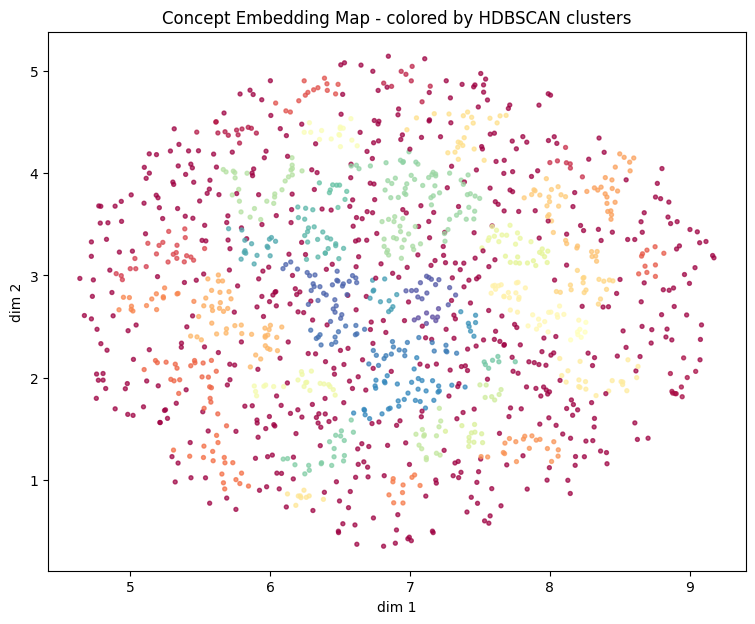

In [ ]:
import hdbscan
import matplotlib.pyplot as plt


# Create a mapping from QID string (bare) to original label string using the filtered labels
qid_to_original_label = {}
if 'labels' in locals(): # Check if labels variable exists (from n2GybfBLDRF3)
   for label_string in labels:
       original_label = label2qid.get(label_string)
       if original_label and isinstance(original_label, str) and (original_label.startswith('wd:Q') or original_label.startswith('Q')):
           bare_qid = original_label.replace('wd:', '')
           qid_to_original_label[bare_qid] = label_string


def get_display_label(filtered_entity_index: int) -> str:
   """Gets the label string from the filtered labels list and attempts to find the original label."""
   label_string = labels[filtered_entity_index]


   # If the label string is a QID, try to find the original label using the updated mapping
   if isinstance(label_string, str) and (label_string.startswith('wd:Q') or label_string.startswith('Q')):
       bare_qid = label_string.replace('wd:', '')
       original_label = qid_to_original_label.get(bare_qid)
       if original_label:
           return f"{original_label} ({label_string})" # Show both if original label found
       else:
           return label_string # Otherwise, show the QID string


   return label_string # Return the label string if it's not a QID


if XY is None:
   print("Dimensionality reduction failed. Cannot perform clustering or plot.")
else:
   # cluster directly in 2-D space
   clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=4)
   labels_hdb = clusterer.fit_predict(XY)


   import numpy as np


   unique, counts = np.unique(labels_hdb, return_counts=True)
   print(dict(zip(unique, counts)))


   n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
   print("Number of clusters:", n_clusters)


   for cid in np.unique(labels_hdb):
       if cid == -1:
           continue
       members = np.where(labels_hdb == cid)[0]
       print(f"\nCluster {cid} ({len(members)} concepts):")
       # Use the new get_display_label function to print labels
       print([get_display_label(members[i]) for i in range(min(10, len(members)))])




   plt.figure(figsize=(9,7))
   plt.scatter(XY[:,0], XY[:,1],
               c=labels_hdb,
               cmap='Spectral', s=8, alpha=0.7)
   plt.title("Concept Embedding Map - colored by HDBSCAN clusters")
   plt.xlabel("dim 1"); plt.ylabel("dim 2")
   plt.show()


In [ ]:
import numpy as np

unique, counts = np.unique(labels_hdb, return_counts=True)
print(dict(zip(unique, counts)))

n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
print("Number of clusters:", n_clusters)

{np.int64(-1): np.int64(590), np.int64(0): np.int64(10), np.int64(1): np.int64(13), np.int64(2): np.int64(8), np.int64(3): np.int64(7), np.int64(4): np.int64(7), np.int64(5): np.int64(17), np.int64(6): np.int64(14), np.int64(7): np.int64(10), np.int64(8): np.int64(25), np.int64(9): np.int64(18), np.int64(10): np.int64(10), np.int64(11): np.int64(16), np.int64(12): np.int64(19), np.int64(13): np.int64(22), np.int64(14): np.int64(18), np.int64(15): np.int64(25), np.int64(16): np.int64(9), np.int64(17): np.int64(18), np.int64(18): np.int64(17), np.int64(19): np.int64(23), np.int64(20): np.int64(9), np.int64(21): np.int64(20), np.int64(22): np.int64(18), np.int64(23): np.int64(14), np.int64(24): np.int64(7), np.int64(25): np.int64(15), np.int64(26): np.int64(7), np.int64(27): np.int64(14), np.int64(28): np.int64(14), np.int64(29): np.int64(14), np.int64(30): np.int64(11), np.int64(31): np.int64(7), np.int64(32): np.int64(14), np.int64(33): np.int64(26), np.int64(34): np.int64(22), np.int64

Missing QIDs to resolve: 449
Fetched 447 new labels.

Cluster 0 (10 concepts):
['8C-prenylisoflavane', '8C-substituted isoflavan', 'Floora', 'similarity', 'monotypic taxon', 'Bacteroidia', 'affine transformation', 'dilation', 'sex - related differences', 'Bacteroidota']

Cluster 1 (13 concepts):
['electrophysiology', 'UCH - L1', 'stearoyl - CoA desaturase', 'the mRNA expression', 'some atypical features', 'Fibonacci number', 'diagnostic test in cardiology', 'Non - Soya Legume - Based Therapeutic Lifestyle Change Diet', 'largest city', 'Inﬂammatory Status', 'gene', 'protein aggregation']

Cluster 2 (8 concepts):
['nervous tissue', 'coenzyme-B sulfoethylthiotransferase activity', 'group 14 hydride', 'biological component', 'none', 'neurons', 'B7 antigens', 'disorders of vitamin D metabolism']

Cluster 3 (7 concepts):
['domain', 'diamino acid', 'Rest tremor', 'dianion', 'DSS', 'immunoregulatory effects', 'Gram - positive bacteria']

Cluster 4 (7 concepts):
['Consumption', 'fecal microbiot

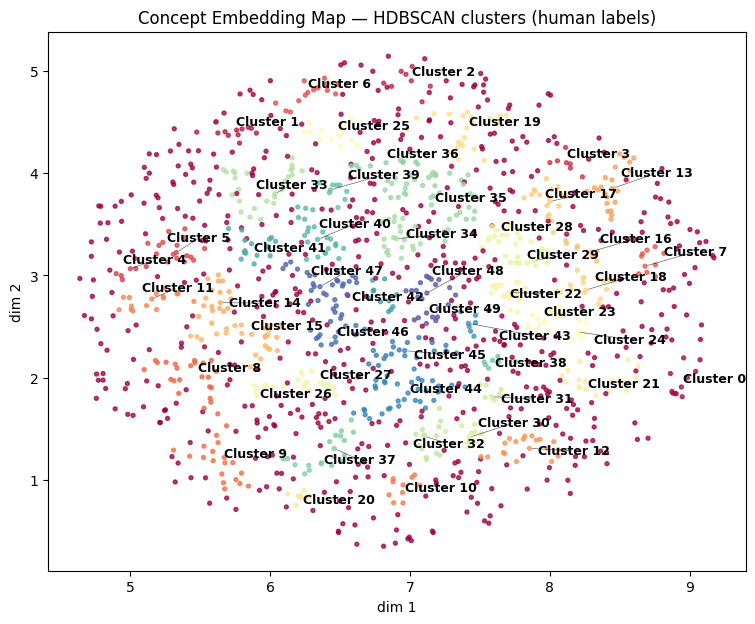

In [ ]:
# Start from your existing mapping: label2qid = {"Lactobacillus":"Q131647", ...}
qid2label = {}
for label, q in label2qid.items():
    if q:
        qid = q[3:] if q.startswith('wd:') else q
        qid2label[qid] = label
import re

def extract_qid(s):
    if isinstance(s, str):
        m = re.search(r'(?:wd:)?(Q\d+)$', s.strip())
        if m: return m.group(1)
    return None

# flatten your cluster terms (whatever structure you have)
all_terms = []
# Check if labels_hdb exists and is not None before iterating
if 'labels_hdb' in locals() and labels_hdb is not None:
    for cid in sorted(set(labels_hdb) - {-1}):
        members = (labels_hdb == cid).nonzero()[0]
        all_terms.extend([labels[i] for i in members])
else:
    # If labels_hdb doesn't exist or is None, use all original labels
    all_terms = labels


missing_qids = sorted({extract_qid(t) for t in all_terms if extract_qid(t)} - set(qid2label))
print(f"Missing QIDs to resolve: {len(missing_qids)}")

import requests, time

def fetch_wikidata_labels(qids, language='en', batch=50, pause=0.5): # Increased pause
    """Return { 'Q123': 'Human-readable label', ... } for the given QIDs."""
    out = {}
    for i in range(0, len(qids), batch):
        chunk = qids[i:i+batch]
        params = {
            'action': 'wbgetentities',
            'format': 'json',
            'ids': '|'.join(chunk),
            'props': 'labels',
            'languages': language,
            'languagefallback': 1,
        }
        try:
            r = requests.get('https://www.wikidata.org/w/api.php', params=params, headers={"User-Agent": "LailahKG/1.0 (mailto:your_email@example.com)"}, timeout=30) # Added User-Agent
            r.raise_for_status()
            data = r.json().get('entities', {})
            for qid, obj in data.items():
                lab = obj.get('labels', {}).get(language, {}).get('value')
                if lab:
                    out[qid] = lab
        except requests.exceptions.RequestException as e:
            print(f"Error fetching batch starting with {chunk[0]}: {e}")
            # Continue with the next batch
            pass
        time.sleep(pause)  # be polite to the API
    return out

# fetch & merge
fetched = fetch_wikidata_labels(missing_qids, language='en')
qid2label.update(fetched)

print(f"Fetched {len(fetched)} new labels.")
def qid_to_label_or_self(x):
    qid = extract_qid(x)
    if qid and qid in qid2label:
        return qid2label[qid]
    return x  # fallback

def pretty_list(terms, max_items=10):
    return [qid_to_label_or_self(t) for t in terms[:max_items]]

# Check if labels_hdb exists and is not None before iterating
if 'labels_hdb' in locals() and labels_hdb is not None:
    for cid in sorted(set(labels_hdb) - {-1}):
        members = (labels_hdb == cid).nonzero()[0]
        terms = [labels[i] for i in members]
        print(f"\nCluster {cid} ({len(members)} concepts):")
        print(pretty_list(terms, max_items=12))

    pretty_labels = [qid_to_label_or_self(x) for x in labels]

    import matplotlib.pyplot as plt
    from adjustText import adjust_text # Import adjustText

    plt.figure(figsize=(9,7))
    plt.scatter(XY[:,0], XY[:,1], c=labels_hdb, cmap='Spectral', s=8, alpha=0.75)
    plt.title("Concept Embedding Map — HDBSCAN clusters (human labels)")
    plt.xlabel("dim 1"); plt.ylabel("dim 2")

    # Check if XY exists before attempting to annotate
    if XY is not None:
        texts = [] # Create a list to hold the text annotations
        for cid in sorted(set(labels_hdb) - {-1}):
            members = (labels_hdb == cid).nonzero()[0]
            if len(members) == 0:
                continue
            center = XY[members].mean(axis=0)
            d = ((XY[members]-center)**2).sum(axis=1)
            rep = members[np.argmin(d)]
            # txt = pretty_labels[rep] # Remove entity label
            # txt = txt if isinstance(txt, str) else "" # Remove entity label
            txt = f"Cluster {cid}" # Only include cluster number
            texts.append(plt.text(XY[rep,0], XY[rep,1], txt, fontsize=9, weight='bold')) # Append text annotation

        # Use adjust_text to prevent overlaps
        adjust_text(
            texts,
            expand_points=(1, 1), # Increase this value to push labels further apart
            force_points=(0.5, 0.5), # Increase this value to force points apart more strongly
            force_text=(0.5, 0.5), # Increase this value to force text apart more strongly
            arrowprops=dict(arrowstyle='-', color='k', lw=0.5, alpha=0.6)
        )

    plt.show()
else:
    print("Clustering results (labels_hdb) not available. Cannot print cluster details or plot.")